In [1]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms
import pathlib
import torchvision
from torch.optim.lr_scheduler import ExponentialLR

import pytorch_lightning as pl

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib
from matplotlib.ticker import MaxNLocator

from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from torchmetrics.functional import accuracy

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import datetime
import time
import random
import os

import sys

# setting device on GPU if available, else CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda:0

NVIDIA GeForce RTX 2080 SUPER
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from os import listdir,makedirs
import cv2
from tqdm import tqdm

DATADIR_Train = "C:/Users/Lisa/Rezanur/Pytorch/MUL_UNI/img set 3/ResNet RGB_T_Tesla/Train"
DATADIR_Test = "C:/Users/Lisa/Rezanur/Pytorch/MUL_UNI/img set 3/ResNet RGB_T_Tesla/Test"
DATADIR_Val = "C:/Users/Lisa/Rezanur/Pytorch/MUL_UNI/img set 3/ResNet RGB_T_Tesla/Val"

In [3]:
CATEGORIES_Train = ["Normal", "DoS", "Fuzz", "Replay"]
CATEGORIES_Test = ["Normal", "DoS", "Fuzz", "Replay"]

In [4]:
training_data = []

def create_training_data():
    for category in CATEGORIES_Train:  # do dogs and cats
        
        path = os.path.join(DATADIR_Train,category)  # create path attack
        class_num = CATEGORIES_Train.index(category)  # get the classification  (0, 1,.... ).

        for img in tqdm(os.listdir(path)):  # iterate over each image 
            try:
                img_array = cv2.imread(os.path.join(path,img))  # convert to array
                new_array = new_array = cv2.resize(img_array, (100, 100))  # resize to normalize data size
                new_array = np.transpose(new_array, (2, 0, 1))
                training_data.append([new_array, class_num])  # add this to our training_data
            except Exception as e:  # in the interest in keeping the output clean...
                pass
            #except OSError as e:
            #    print("OSErrroBad img most likely", e, os.path.join(path,img))
            #except Exception as e:
            #    print("general exception", e, os.path.join(path,img))

create_training_data()

print(len(training_data))

100%|██████████| 1224/1224 [00:02<00:00, 472.48it/s]

22447


In [5]:
testing_data = []

def create_training_data():
    for category in CATEGORIES_Test:  # do dogs and cats

        path = os.path.join(DATADIR_Test,category)  # create path attack
        class_num = CATEGORIES_Test.index(category)  # get the classification  (0, 1,.... ).

        for img in tqdm(os.listdir(path)):  # iterate over each image 
            try:
                img_array = cv2.imread(os.path.join(path,img))  # convert to array
                new_array = cv2.resize(img_array, (100, 100))  # resize to normalize data size
                new_array = np.transpose(new_array, (2, 0, 1))
                testing_data.append([new_array, class_num])  # add this to our training_data
            except Exception as e:  # in the interest in keeping the output clean...
                pass
            #except OSError as e:
            #    print("OSErrroBad img most likely", e, os.path.join(path,img))
            #except Exception as e:
            #    print("general exception", e, os.path.join(path,img))

create_training_data()

print(len(testing_data))

100%|██████████| 883/883 [00:01<00:00, 467.17it/s]

9919


In [6]:
val_data = []

def create_training_data():
    for category in CATEGORIES_Test:  # do dogs and cats

        path = os.path.join(DATADIR_Val,category)  # create path attack
        class_num = CATEGORIES_Test.index(category)  # get the classification  (0, 1,.... ).

        for img in tqdm(os.listdir(path)):  # iterate over each image 
            try:
                img_array = cv2.imread(os.path.join(path,img))  # convert to array
                new_array = cv2.resize(img_array, (100, 100))  # resize to normalize data size
                new_array = np.transpose(new_array, (2, 0, 1))
                val_data.append([new_array, class_num])  # add this to our training_data
            except Exception as e:  # in the interest in keeping the output clean...
                pass
            #except OSError as e:
            #    print("OSErrroBad img most likely", e, os.path.join(path,img))
            #except Exception as e:
            #    print("general exception", e, os.path.join(path,img))

create_training_data()

print(len(testing_data))

100%|██████████| 1183/1183 [00:02<00:00, 445.61it/s]

9919


In [7]:
def set_seed(seed=0):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(0)

In [8]:
class AlexNet(nn.Module):
    
    def __init__(self, num_classes):
        
        super().__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size = 11, stride = 4, padding = 2),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size = 3, stride = 2),
            
            nn.Conv2d(64, 192, kernel_size = 5, padding = 2),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size = 3, stride = 2),
            
            nn.Conv2d(192, 384, kernel_size = 3, padding = 1),
            nn.ReLU(inplace = True),
            
            nn.Conv2d(384, 256, kernel_size = 3, padding = 1),
            nn.ReLU(inplace = True),
            
            nn.Conv2d(256, 256, kernel_size = 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size = 3, stride = 2)
        )
        
        self.avgpool = nn.AdaptiveAvgPool2d((6,6))
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            
            nn.Linear(256*6*6, 4096),
            nn.ReLU(inplace = True),
            
            nn.Linear(4096, 4096),
            nn.ReLU(inplace = True),
            
            nn.Linear(4096, num_classes)
        )
        
    def forward(self, x):
        
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), 256*6*6)
        logit = self.classifier(x)
        
        return logit

In [9]:
class EarlyStopping:
    def __init__(self, mode, path, patience=3, delta=0):
        if mode not in {'min', 'max'}:
            raise ValueError("Argument mode must be one of 'min' or 'max'.")
        if patience <= 0:
            raise ValueError("Argument patience must be a postive integer.")
        if delta < 0:
            raise ValueError("Argument delta must not be a negative number.")
            
        self.mode = mode
        self.patience = patience
        self.delta = delta
        self.path = path
        self.best_score = np.inf if mode == 'min' else -np.inf
        self.counter = 0
        
    def _is_improvement(self, val_score):
        """Return True iff val_score is better than self.best_score."""
        if self.mode == 'max' and val_score > self.best_score + self.delta:
            return True
        elif self.mode == 'min' and val_score < self.best_score - self.delta:
            return True
        return False
        
    def __call__(self, val_score, model):
        """Return True iff self.counter >= self.patience.
        """
        
        if self._is_improvement(val_score):
            self.best_score = val_score
            self.counter = 0
            torch.save(model.state_dict(), self.path)
            print('Val loss improved. Saved model.')
            return False
        else:
            self.counter += 1
            print(f'Early stopping counter: {self.counter}/{self.patience}')
            if self.counter >= self.patience:
                print(f'Stopped early. Best val loss: {self.best_score:.4f}')
                return True

In [10]:
def train_one_epoch(model, train_loader, optimizer, device, criterion):
    """Train model for one epoch and return the mean train_loss."""
    model.train()
    running_loss_train = 0
    for inputs, labels in train_loader:
        labels = labels.type(torch.LongTensor)
        inputs = inputs.type(torch.cuda.FloatTensor)
        #labels = labels.type(torch.cuda.FloatTensor)
        inputs, labels = inputs.to(device=device), labels.to(device=device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss_train += loss.item()
    train_loss = running_loss_train / len(train_loader.dataset)
    return train_loss

In [11]:
def validate(model, valid_loader, device, criterion):
    """Validate model and return the accuracy and mean loss."""
    model.eval()
    correct = 0
    running_loss_val = 0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            labels = labels.type(torch.LongTensor)
            inputs = inputs.type(torch.cuda.FloatTensor)
            #labels = labels.type(torch.cuda.FloatTensor)
            inputs, labels = inputs.to(device=device), labels.to(device=device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            pred = outputs.argmax(dim=1)
            correct += pred.eq(labels).sum().item()
            running_loss_val += loss.item()
    val_acc = correct / len(valid_loader.dataset)
    val_loss = running_loss_val / len(valid_loader.dataset)
    return val_acc, val_loss

In [12]:
def fit(model, train_loader, valid_loader, learning_rate, num_epochs):
    criterion = nn.CrossEntropyLoss(reduction='sum')
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    es = EarlyStopping(mode='min', path='./AlexNet_Adam_T_Tesla.pth', patience=10)
    model = model.to(device)
    scheduler = ExponentialLR(optimizer, gamma=0.1)

    for epoch in range(1, num_epochs + 1):
        train_loss = train_one_epoch(model, train_loader, optimizer, device, criterion)
        val_acc, val_loss = validate(model, valid_loader, device, criterion)
        scheduler.step()
        print(f'Epoch {epoch:2}/{num_epochs}',
              f'train loss: {train_loss:.4f}',
              f'val loss: {val_loss:.4f}',
              f'val acc: {val_acc:.2%}',
              sep=' | '
             )
        if es(val_loss, model):
            break

In [14]:
TRAIN_BATCH_SIZE = 64
VALID_BATCH_SIZE = 32
NUM_EPOCHS = 50
LEARNING_RATE = 1e-3
NUM_WORKERS = 0
PIN_MEMORY = False

train_loader = torch.utils.data.DataLoader(training_data, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=VALID_BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)


model = AlexNet(num_classes = 4).to(device)
start = time.time()
fit(model, train_loader, valid_loader, learning_rate=LEARNING_RATE, num_epochs=NUM_EPOCHS)
print(f'Total training time: {time.time() - start}')
model.load_state_dict(torch.load('AlexNet_Adam_T_Tesla.pth'))

Epoch  1/50 | train loss: 6.1451 | val loss: 0.3919 | val acc: 85.41%
Val loss improved. Saved model.
Epoch  2/50 | train loss: 0.1065 | val loss: 0.2792 | val acc: 90.08%
Val loss improved. Saved model.
Epoch  3/50 | train loss: 0.0924 | val loss: 0.2369 | val acc: 90.91%
Val loss improved. Saved model.
Epoch  4/50 | train loss: 0.0912 | val loss: 0.2335 | val acc: 91.11%
Val loss improved. Saved model.
Epoch  5/50 | train loss: 0.0898 | val loss: 0.2332 | val acc: 91.15%
Val loss improved. Saved model.
Epoch  6/50 | train loss: 0.0900 | val loss: 0.2332 | val acc: 91.15%
Val loss improved. Saved model.
Epoch  7/50 | train loss: 0.0898 | val loss: 0.2332 | val acc: 91.15%
Val loss improved. Saved model.
Epoch  8/50 | train loss: 0.0909 | val loss: 0.2332 | val acc: 91.15%
Val loss improved. Saved model.
Epoch  9/50 | train loss: 0.0905 | val loss: 0.2332 | val acc: 91.15%
Val loss improved. Saved model.
Epoch 10/50 | train loss: 0.0902 | val loss: 0.2332 | val acc: 91.15%
Early stoppi

<All keys matched successfully>

In [13]:
# Load
TRAIN_BATCH_SIZE = 64
VALID_BATCH_SIZE = 32
NUM_EPOCHS = 50
LEARNING_RATE = 1e-3
NUM_WORKERS = 0
PIN_MEMORY = False

test_loader = torch.utils.data.DataLoader(testing_data, batch_size=VALID_BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

model = AlexNet(num_classes = 4)
model.load_state_dict(torch.load('C:/Users/Lisa/Rezanur/Pytorch/MUL_UNI/img set 3/AlexNet RGB_T_Tesla/AlexNet_Adam_T_Tesla.pth'))
model.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [14]:
def get_prediction(model, dataloader):
    with torch.no_grad():
        model = model.to(device)
        model.eval()
        prediction = np.zeros(len(dataloader.dataset))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for images, target in dataloader:
            if device:
                images = images.type(torch.cuda.FloatTensor)
            prediction[k:k+len(images)] = np.argmax(model(images).data.cpu().numpy(), axis=1)
            labels[k:k+len(images)] = target.numpy()
            k += len(images)
    return prediction, labels

In [16]:
pred = get_prediction(model, test_loader)
y_pred = pred[0]
y_test = pred[1]

In [17]:
from sklearn.metrics import confusion_matrix

#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

print(cf_matrix)

[[1941    0   59    0]
 [   0 2887  149    0]
 [  59    3 3938    0]
 [ 474    0    1  408]]


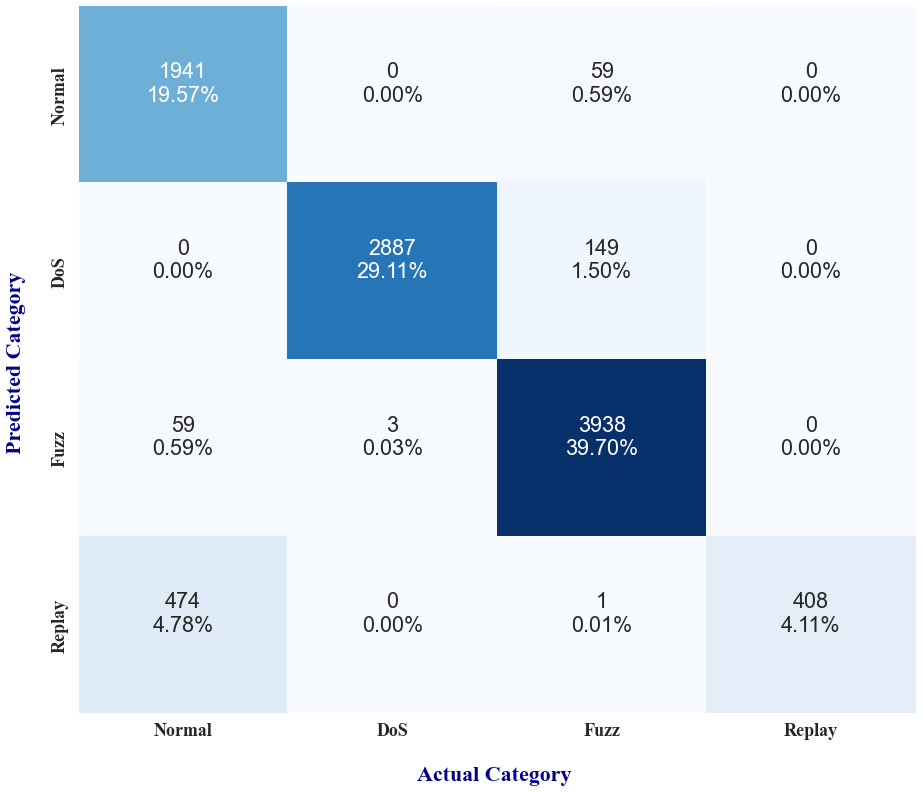

In [18]:
#group_names = ['True Neg','False Pos','False Neg','True Pos','True Pos','True Pos','True Pos','True Pos','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n" for v1, v2 in
          zip(group_counts,group_percentages)]

labels = np.asarray(labels).reshape(4,4)
sns.set(rc={'figure.figsize':(15,13)})
sns.set(font_scale=1.8) #edited as suggested
ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', cbar=False)


ax.set_xlabel('\nActual Category ', fontname="Times New Roman", size=22,fontweight="bold")
ax.set_ylabel('Predicted Category \n', fontname="Times New Roman", size=22,fontweight="bold");
#ax.text(0.30, 4.65, Confusion Matrix CNN Multiclass Classification',fontsize=25,fontweight="bold")

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(["Normal", "DoS", "Fuzz", "Replay"],fontweight="bold", fontname="Times New Roman", size=18)
ax.yaxis.set_ticklabels(["Normal", "DoS", "Fuzz", "Replay"],fontweight="bold", fontname="Times New Roman", size=18)
ax.xaxis.label.set_color('darkblue')
ax.yaxis.label.set_color('darkblue')
## Display the visualization of the Confusion Matrix.
plt.show()

In [19]:
from sklearn.metrics import classification_report
class_names = ["Normal", "DoS", "Fuzz", "Replay"]
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

      Normal       0.78      0.97      0.87      2000
         DoS       1.00      0.95      0.97      3036
        Fuzz       0.95      0.98      0.97      4000
      Replay       1.00      0.46      0.63       883

    accuracy                           0.92      9919
   macro avg       0.93      0.84      0.86      9919
weighted avg       0.94      0.92      0.92      9919



ROC AUC score: 0.9081163835199646


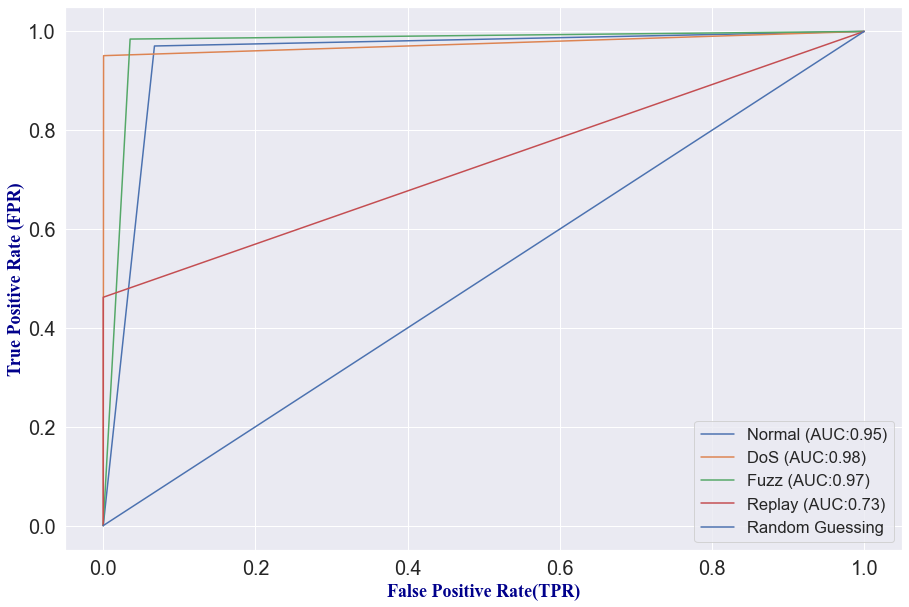

In [20]:
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score


target= ["Normal", "DoS", "Fuzz", "Replay"]

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (15, 10))
sns.set(font_scale=1.5) #edited as suggested

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)


print('ROC AUC score:', multiclass_roc_auc_score(y_test, y_pred))

c_ax.set_xlabel('False Positive Rate(TPR)', fontname="Times New Roman", size=18, fontweight="bold", color='darkblue')
c_ax.set_ylabel('True Positive Rate (FPR)', fontname="Times New Roman", size=18, fontweight="bold", color='darkblue')
#c_ax.text(0.16, -0.22, 'Fig. 6. (c) RUC Score CNN Multiclass Class Classification', fontname="Times New Roman",fontsize=25,fontweight="bold")
c_ax.legend(loc="lower right")